In [1]:
import os
import dask.dataframe as dd
import datetime as dt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Ouverture des bases de données
df_cct = pd.read_parquet("/home/onyxia/work/cct.parquet")


In [3]:
#Un peu de nettoyage

df_cct["Amount"] = df_cct["Amount"].str.replace("$","")
df_cct["Amount"] = df_cct["Amount"].astype(float)
df_cct["Is Fraud?"].mask(df_cct["Is Fraud?"] == "Yes", 1 , inplace = True)
df_cct["Is Fraud?"].mask(df_cct["Is Fraud?"] == "No", 0 , inplace = True)

In [4]:
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]

In [5]:
df_not_fraud = df_cct[df_cct["Is Fraud?"] == 0]

## 0. Cards

In [6]:
df_cards = pd.read_csv("/home/onyxia/work/sd254_cards.csv")
df_cards.rename(columns={"CARD INDEX" : "Card"}, inplace=True)

In [7]:
df_cct = pd.merge(df_cct,df_cards[["User", "Card", "Card Brand", "Card Type", "Credit Limit", "Year PIN last Changed"]], on=["User","Card"], how='left')

In [8]:
df_cct["Credit Limit"] = df_cct["Credit Limit"].str.replace("$","")
df_cct["Credit Limit"] = df_cct["Credit Limit"].astype(float)

## I. Time intervals between transactions

In [9]:
#Création des variables 'timestamp', 'delta_t_s' et 'delta_t_s_card'
def time(dataframe):
   dataframe[['Hours', 'Minutes']] = dataframe.Time.str.split(":", n=1, expand=True) #scinder la colonne Time en 2
   dataframe["Hours"] = dataframe["Hours"].astype(int)
   dataframe["Minutes"] = dataframe["Minutes"].astype(int)
   #Créer une colonne 'Timestamp' : format année, mois, jour, heure, minute:
   timestamp = pd.to_datetime(dataframe[["Year",'Month','Day','Hours','Minutes']], format = '%Y:%M:%D%:%H:%M')
   date = pd.to_datetime(dataframe[["Year",'Month','Day']], format = '%Y:%M:%D%')
   dataframe["date"] = date.values
   dataframe["timestamp"] = timestamp.values
   dataframe["delta_t_card"] = (timestamp-timestamp.shift()) #calculer l'intervalle de temps entre
   #deux transactions de la même carte et du même user

   #Convertir delta_t_card en secondes et mettre à 0 les temps négatifs 
   #(ici, dataframe ordonné en fonction de l'user et de la carte, et non de la chronologie):
   dataframe["delta_t_s_card"] = dataframe["delta_t_card"].dt.total_seconds().fillna(0).astype(int)
   dataframe["delta_t_s_card"] = dataframe["delta_t_s_card"].mask(dataframe["delta_t_s_card"] < 0, 0)

   #Réordonner les transactions en fonction du User et de la chronoogie de ses transactions : 
   dataframe = dataframe.sort_values(["User", "Year","Month","Day","Hours","Minutes"], ascending=[True,True,True,True,True,True]).reset_index(drop=True)
   timestamp2 = pd.to_datetime(dataframe[["Year",'Month','Day','Hours','Minutes']], format = '%Y:%M:%D%:%H:%M')
   dataframe['delta_t'] = (timestamp2-timestamp2.shift()) #différence de temps entre deux transactions du même user
   dataframe["delta_t_s"] = dataframe["delta_t"].dt.total_seconds().fillna(0).astype(int) #pour la première
   #transaction, fixer le delta_t_s à 0
   dataframe["delta_t_s"] = dataframe["delta_t_s"].mask(dataframe["delta_t_s"] < 0, 0)

   dataframe = dataframe[['User', 'Card', 'date', 'timestamp', 'Year', 'Month', 'Day', 'Hours', 'Amount', 'Use Chip',
        "Card Brand", "Card Type", "Credit Limit", "Year PIN last Changed",
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'delta_t_s','delta_t_s_card','Is Fraud?']] #ordonner et sélectionner les colonnes
   
   return dataframe



In [10]:
df_cct = time(df_cct)

#### 1. Day of the week

In [11]:
df_cct['day_of_week'] = df_cct['date'].dt.day_name()

#### 2. Analysis of time intervals between transactions

In [12]:
df_cct["delta_t_s"].mean() #average time between two transactions ~ 8 hours

29590.274720444173

In [13]:
df_cct["delta_t_s"].median() #median time between two transactions ~ 4 hours

13920.0

In [14]:
df_cct["delta_t_s"].max()

417268260

In [15]:
import matplotlib.pyplot as plt

In [16]:
df_cct_1 = df_cct[df_cct["delta_t_s"]> 0]

Text(0, 0.5, 'count')

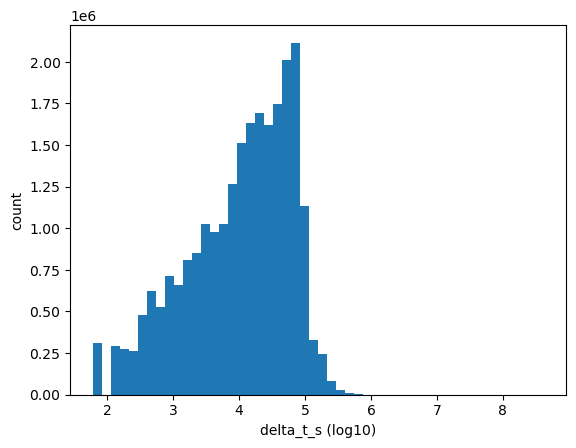

In [17]:
import numpy as np
plt.hist(np.log(df_cct_1["delta_t_s"].to_numpy())/np.log(10),bins=50) #plot distribution of time intervals
#abscisse : log10 time_interval_in_seconds
plt.xlabel("delta_t_s (log10)")
plt.ylabel("count")


In [18]:
df_cct["delta_t_s_card"].mean()  #average time between two transactions of same card ~ 18 hours

65925.91032726587

In [19]:
import numpy as np

## II. Ratio amount of transaction over daily income

In [20]:
df_users = pd.read_csv("/home/onyxia/work/sd254_users.csv")
df_users['Yearly Income - Person'] = df_users['Yearly Income - Person'].str.replace("$","")
df_users["daily_income"] = df_users['Yearly Income - Person'].astype(np.int)/365
df_users.reset_index(inplace=True)
df_users.rename(columns={"index":"User"},inplace=True)
df_cct["amt/daily_income"] = df_cct["Amount"]/pd.merge(df_cct,df_users[["User","daily_income"]], on="User",how="left")["daily_income"]

# absolute amount? there are about 1 million transactions with negative amounts

## III. Retired

In [21]:
def retired(row):
    if row["Current Age"] >= row["Retirement Age"]:
        return 1
    else:
        return 0

In [22]:
df_users.loc[:,"Retired"] = df_users.apply(retired, axis=1)

In [23]:
df_cct["Retired"] = pd.merge(df_cct,df_users[["User", "Retired"]], on = "User", how="left")["Retired"]

## IV. Daily amount per card

In [24]:
def calc_rolling_sum(dataf, column=None, setting='1D'):
    return (dataf
            .groupby(['User', 'Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).sum())) #absolute sum of amounts

In [25]:
df_cct["abs_amount"] = df_cct["Amount"].abs() #absolute value of transaction's amount

In [26]:
df_cct["daily_amount"] = (df_cct
.set_index('date')
.assign(daily_amount=lambda d: calc_rolling_sum(d, column='abs_amount')))["daily_amount"].values

## V. Daily, weekly, monthly Declines per card

In [27]:
def calc_rolling_decline(dataf, column=None, setting='1D'):
    return (dataf
        .groupby(['User',"Card"])[column]
        .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [28]:
def calc_rolling_decline_mth(dataf, column=None, setting='30D'):
    return (dataf
        .groupby(['User',"Card"])[column]
        .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [29]:
def calc_rolling_decline_wk(dataf, column=None, setting='7D'):
    return (dataf
        .groupby(['User',"Card"])[column]
        .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [30]:
df_cct["nb_daily_declines_card"] = (df_cct
.set_index('date')
.assign(nb_daily_declines_card=lambda d: calc_rolling_decline(d, column="Errors?")))["nb_daily_declines_card"].values

In [31]:
df_cct["nb_weekly_declines_card"] = (df_cct
.set_index('date')
.assign(nb_weekly_declines_card=lambda d: calc_rolling_decline_wk(d, column="Errors?")))["nb_weekly_declines_card"].values

In [32]:
df_cct["nb_monthly_declines_card"] = (df_cct
.set_index('date')
.assign(nb_monthly_declines_card=lambda d: calc_rolling_decline_mth(d, column="Errors?")))["nb_monthly_declines_card"].values

## VI. Bad pin

In [33]:
bad_pin = ['Bad PIN','Bad PIN,Insufficient Balance','Bad PIN,Technical Glitch']

In [34]:
df_cct["bad_pin"] = df_cct["Errors?"].apply(lambda x: 1 if x in bad_pin else 0)

## VII. Insufficient balance

In [35]:
insufficient_balance = ['Insufficient Balance','Bad PIN,Insufficient Balance',
'Insufficient Balance,Technical Glitch','Bad Card Number,Insufficient Balance',
'Bad CVV,Insufficient Balance','Bad Expiration,Insufficient Balance',
'Bad Zipcode,Insufficient Balance','Bad Card Number,Bad Expiration,Insufficient Balance']

In [36]:
df_cct["insufficient_balance"] = df_cct["Errors?"].apply(lambda x: 1 if x in insufficient_balance else 0)

## VIII. Ratio: Number of transaction per hour over average number of transactions per hour during the last 30 days

In [37]:
def calc_rolling_nbt_h(dataf, column=None, setting='1H'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [38]:
df_cct["hourly_nbt"] = (df_cct
.set_index('timestamp')
.assign(hourly_nbt=lambda d: calc_rolling_nbt_h(d, column= "Amount")))["hourly_nbt"].values

In [39]:
def calc_rolling_av_30d_nbt(dataf, column=None, setting='30D'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).mean()))

In [40]:
df_cct["last_30_days_av_hourly_nbt"] = (df_cct
.set_index('timestamp')
.assign(last_30_days_av_hourly_nbt=lambda d: calc_rolling_av_30d_nbt(d, column= "hourly_nbt")))["last_30_days_av_hourly_nbt"].values

In [41]:
df_cct["hr_nbt/last_30d_av_hr_nbt"] = df_cct["hourly_nbt"]/df_cct["last_30_days_av_hourly_nbt"]

## IX. Ratio: Number of transaction per day over average number of transactions per day during the last 30 days

In [42]:
def calc_rolling_nbt_1d(dataf, column=None, setting='1D'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [43]:
df_cct["daily_nbt"] = (df_cct
.set_index('timestamp')
.assign(daily_nbt=lambda d: calc_rolling_nbt_1d(d, column= "Amount")))["daily_nbt"].values

In [44]:
def calc_rolling_av_30d_nbt(dataf, column=None, setting='30D'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).mean()))

In [45]:
df_cct["last_30_days_av_daily_nbt"] = (df_cct
.set_index('timestamp')
.assign(last_30_days_av_daily_nbt=lambda d: calc_rolling_av_30d_nbt(d, column= "daily_nbt")))["last_30_days_av_daily_nbt"].values

In [46]:
df_cct["day_nbt/last_30d_av_day_nbt"] = df_cct["daily_nbt"]/df_cct["last_30_days_av_daily_nbt"]

## X. Ratio: total amount of transactions over number of transactions for the 3 last days per card

In [47]:
def calc_rolling_3d_nbt(dataf, column=None, setting='3D'):
    return (dataf
            .groupby(['User','Card'])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).count()))

In [48]:
df_cct["last_3d_nbt"] = (df_cct
.set_index('date')
.assign(last_3d_nbt=lambda d: calc_rolling_3d_nbt(d, column= "Amount")))["last_3d_nbt"].values

In [49]:
def calc_rolling_3d_sum(dataf, column=None, setting='3D'):
    return (dataf
            .groupby(['User',"Card"])[column]
            .transform(lambda d: d.rolling(setting, min_periods=1).sum())) 

In [50]:
df_cct["last_3d_amt"] = (df_cct
.set_index('date')
.assign(last_3d_amt=lambda d: calc_rolling_3d_sum(d, column='abs_amount')))["last_3d_amt"].values

In [51]:
df_cct["last_3d_amt/nbt"] = df_cct["last_3d_amt"]/df_cct["last_3d_nbt"]


## XI. Ratio: total amount of transactions over number of transactions since last Thursday/Sunday per card

## Final

In [52]:
df_cct.columns

Index(['User', 'Card', 'date', 'timestamp', 'Year', 'Month', 'Day', 'Hours',
       'Amount', 'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit',
       'Year PIN last Changed', 'Merchant Name', 'Merchant City',
       'Merchant State', 'Zip', 'MCC', 'Errors?', 'delta_t_s',
       'delta_t_s_card', 'Is Fraud?', 'day_of_week', 'amt/daily_income',
       'Retired', 'abs_amount', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hourly_nbt', 'last_30_days_av_hourly_nbt',
       'hr_nbt/last_30d_av_hr_nbt', 'daily_nbt', 'last_30_days_av_daily_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_nbt', 'last_3d_amt',
       'last_3d_amt/nbt'],
      dtype='object')

In [55]:
df_cct_final = df_cct[['User', 'Card', 'Year', 'Month', 'Day', 'Hours',
       'Amount', 'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit',
       'Year PIN last Changed', 'Merchant City',
       'Merchant State', 'delta_t_s',
       'delta_t_s_card', 'day_of_week', 'amt/daily_income',
       'Retired', 'daily_amount', 'nb_daily_declines_card',
       'nb_weekly_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Is Fraud?']] #selecting final features to be used for ML models

In [57]:
df_cct_final.to_parquet("/home/onyxia/work/df_cct_final.parquet")